In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import seaborn as sns
from ionpy.analysis import ResultsLoader
from ese.experiment.experiment.ese_exp import CalibrationExperiment
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE/"

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
train_path = f"{root}/training/10_23_23_Dense_WMH"

dfc = rs.load_configs(
    train_path,
    properties=False,
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# Set the device
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

best_exp = rs.get_best_experiment(
    df=rs.load_metrics(dfc),
    exp_class=CalibrationExperiment,
    device="cuda"
)

  0%|          | 0/2 [00:00<?, ?it/s]

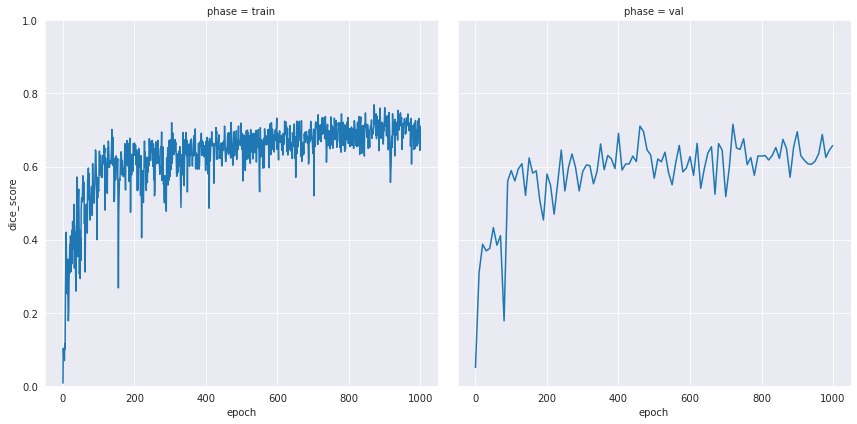

In [4]:
best_exp.vis_loss_curves(height=6)

In [5]:
from ese.experiment.analysis.inference import load_cal_inference_stats

inference_path = f"{root}/inference/11_11_23_WMH_Weighted_SUME"

cal_inference_info = load_cal_inference_stats(
    log_dir=inference_path,
)

In [6]:
cal_inference_info.keys()

dict_keys(['pixel_info_dicts', 'image_info_df', 'metadata'])

In [7]:
metadata = cal_inference_info['metadata']

In [8]:
metadata.keys()

Index(['calibration.conf_interval_end', 'calibration.conf_interval_start',
       'calibration.num_bins', 'dataset._class', 'dataset.annotator',
       'dataset.axis', 'dataset.num_slices', 'dataset.preload',
       'dataset.slicing', 'dataset.split', 'dataset.task', 'dataset.version',
       'log.log_interval', 'log.root', 'log.track_image_level',
       'log.track_pixel_level', 'model.exp_root', 'model.num_workers',
       'log_set'],
      dtype='object')

In [9]:
# This function will take in a dictionary of pixel meters and a metadata dataframe
# from which to select the log_set corresponding to particular attributes, then 
# we index into the dictionary to get the corresponding pixel meters.
def select_pixel_dict(pixel_meter_logdict, metadata, kwargs):
    # Select the metadata
    metadata = metadata.select(**kwargs)
    # Get the log set
    assert len(metadata) == 1, "More than one log set found."
    log_set = metadata['log_set'].iloc[0]
    # Return the pixel dict
    return pixel_meter_logdict[log_set]

## Pixel-level Analysis

In [10]:
# from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence

# for split in ["train", "val", "cal"]: 
#     split_preds_dict = select_pixel_dict(
#         pixel_meter_logdict=cal_inference_info["pixel_info_dicts"], 
#         metadata=cal_inference_info["metadata"],
#         kwargs={"dataset.split": split}
#     ) 
#     # Plot the accuracy vs confidence for this split.
#     viz_accuracy_vs_confidence(
#         split_preds_dict,
#         title=f"WMH Confidence vs Accuracy per (Bin and Predicted Label, {split} split)",
#         x="pred_label",
#         col="bin_num",
#         kind="bar",
#         add_avg=False,
#         facet_kws={'sharey': False, 'sharex': False}
#         )

In [11]:
# from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence

# for split in ["train", "val", "cal"]: 
#     split_preds_dict = select_pixel_dict(
#         pixel_meter_logdict=cal_inference_info["pixel_info_dicts"], 
#         metadata=cal_inference_info["metadata"],
#         kwargs={"dataset.split": split}
#     ) 
#     # Plot the accuracy vs confidence for this split.
#     viz_accuracy_vs_confidence(
#         split_preds_dict,
#         title=f"WMH Confidence vs Accuracy per (Bin and Num Neighbors, split: {split})",
#         x="num_neighbors",
#         col="bin_num",
#         kind="bar",
#         add_avg=False,
#         add_proportion=True,
#         facet_kws={'sharey': False, 'sharex': False},
#         )

## Image-level Analysis

In [12]:
image_info_df = cal_inference_info['image_info_df']

In [13]:
from ese.experiment.analysis.utils import reorder_splits

unique_image_df = reorder_splits(image_info_df.drop_constant())

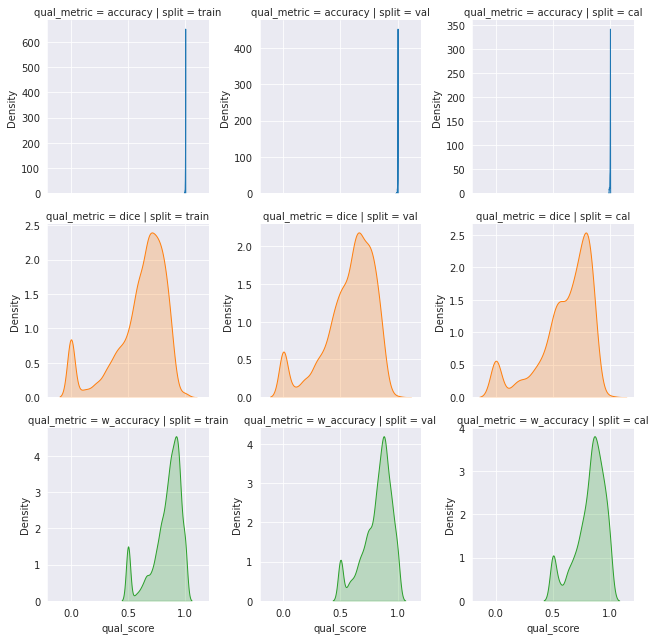

In [14]:
# Now using seaborn's FacetGrid to create the KDE plots for the 'accuracy' column for each 'split'.
g = sns.FacetGrid(unique_image_df, hue="qual_metric", col="split", row="qual_metric", sharex=True, sharey=False)
g = g.map(sns.kdeplot, "qual_score", fill=True)

# Adjusting the layout
g.fig.tight_layout()

In [15]:
unique_image_df["cal_metric_type"] = unique_image_df["cal_metric"].apply(lambda x: x.split(" ")[-1])

In [16]:
# from ese.experiment.analysis.err_diagrams import viz_cal_metric_corr

# viz_cal_metric_corr(
#     unique_image_df,
#     title="WMH Calibration Metric NEGATED Correlation",
#     negate=True,
#     height=7
# )

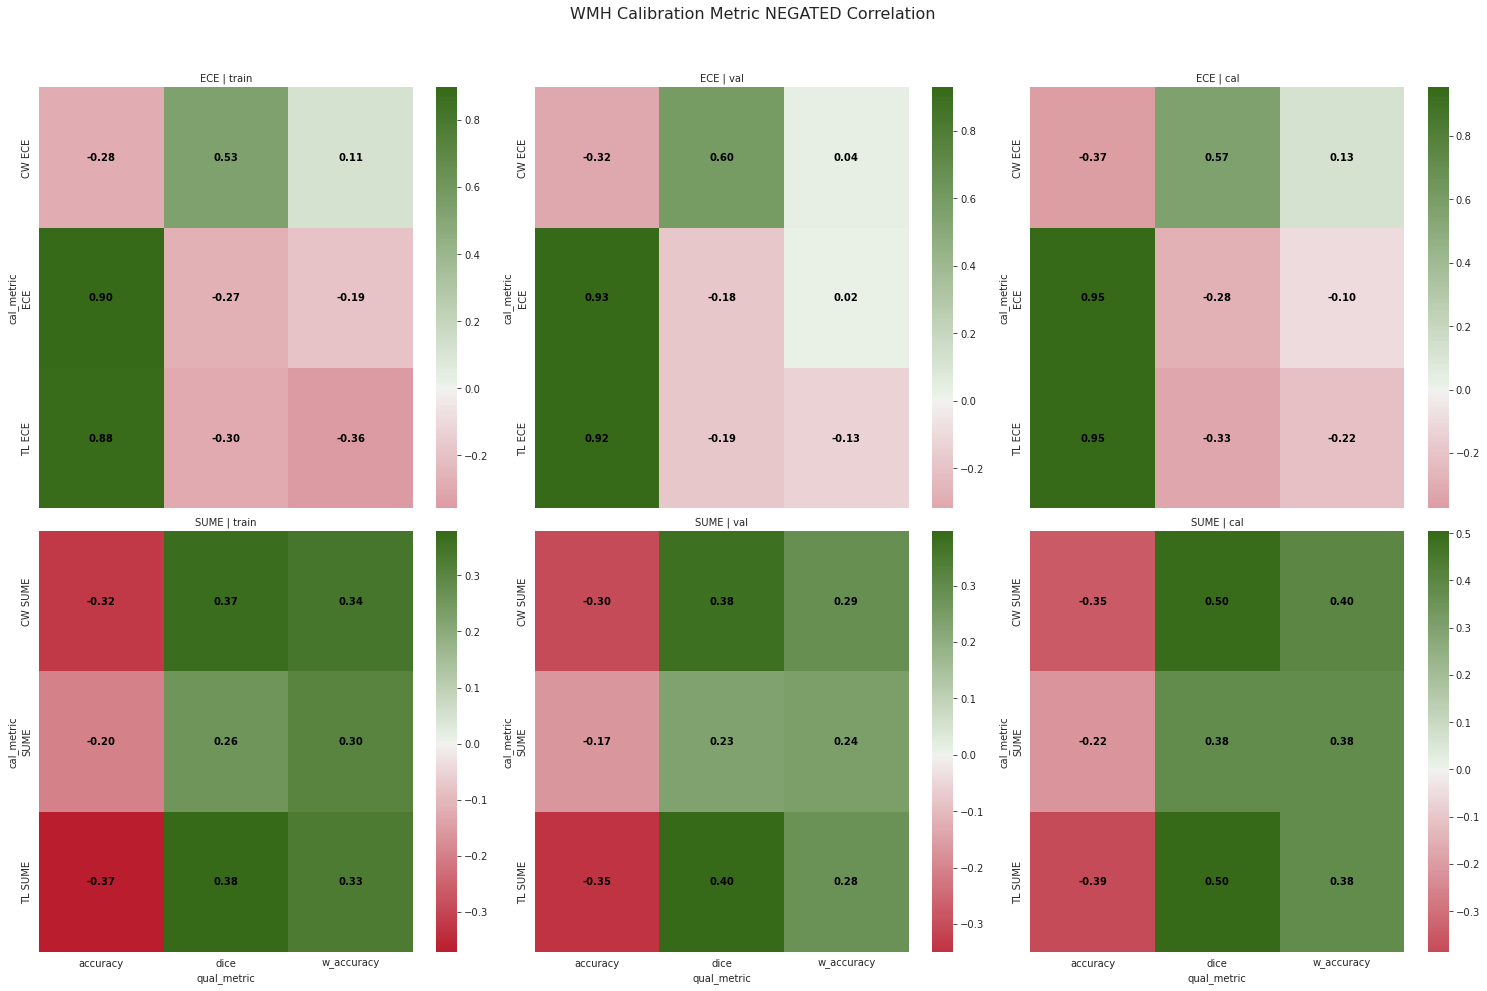

In [18]:
from ese.experiment.analysis.err_diagrams import viz_cal_metric_corr

viz_cal_metric_corr(
    unique_image_df,
    title="WMH Calibration Metric NEGATED Correlation",
    row="cal_metric_type",
    negate=True,
    height=7
)